# (09) Sim -- slight changes ```dim=17```

**Motivation**: Study its behavior, choose appropriate ```accept_n```, ```min_obj_size```, etc. Finally, generate and save. 

***Note***: The following are changed from previous iteration:
- Changed ```obj_r``` back to $0.25$, the original value used in the NeurIPS paper.
- Changed ```obj_bound``` from $0.97 \rightarrow 1.0$ so now all alphas are accepted when sampling obj pos.
<br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from figures.fighelper import *
from analysis.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def _do_pca(a):
    a = flatten_arr(a, ndim_end=0, ndim_start=1)
    u, s, v = sp_lin.svd(a, full_matrices=False, compute_uv=True)
    s *= 100 / s.sum()
    titles = [f"{e:0.1f} %" for e in s]
    pcs = v.reshape(-1, of.dim, of.dim, 2)
    return s, pcs, titles


def _plot_singular_values(s, thres=90):
    fig, axes = create_figure(2, 1, (13, 7), sharex='all')
    axes[0].plot(s, marker='.')
    axes[1].plot(np.cumsum(s), lw=3, marker=None)

    idx = np.where(np.cumsum(s) > thres)[0][0]
    axes[1].axvline(
        idx, color='g', ls=':', lw=1.5,
        label=f'{idx} dimensions',
    )
    axes[1].axhline(
        thres, color='magenta', ls=':', lw=1.5,
        label=f'{thres}% of variance',
    )
    axes[1].legend()

    axes[1].axhline(0, color='k', ls='--', lw=1.2)
    axes[1].axhline(100, color='k', ls='--', lw=1.2)
    axes[1].set_ylim((-3, 103))
    add_grid(axes)
    plt.show()

def _sizes_hist(of, obj_i: int = 0):
    fig, axes = create_figure(2, 1, (10, 5))
    size_pix = of.objects[obj_i].size * of.dim ** 2
    sns.histplot(size_pix, bins=np.linspace(0, 400, 401) - 0.5, stat='percent', ax=axes[0])
    sns.histplot(size_pix, bins=np.linspace(0, 400, 401) - 0.5, stat='percent', ax=axes[1])
    axes[1].set_xlim((-1, 81))
    
    for color, thres in zip(['magenta', 'k', 'g', 'r', 'k'], [2, 4, 6, 8, 10]):
        lbl = f'{100 * (size_pix < thres).sum() / of.n:0.1f}% smaller than {thres} pixels'
        for ax in axes.flat:
            ax.axvline(thres, color=color, ls='--', lw=1.3, label=lbl)
    axes[0].legend(fontsize=12)
    
    plt.show()

## Accept explore

In [3]:
from skimage.transform import resize

kws = dict(
    n=int(1e3),
    dim=17,
    fov=45.0,
    obj_r=0.25,
    obj_bound=1.0,
    obj_zlim=(0.5, 1.0),
    vlim_obj=(0.01, 1.0),
    vlim_slf=(0.01, 1.0),
    residual=False,
    z_bg=1.0,
    seed=0,
)
print(kws)

min_obj_size = 3.5

{
    'n': 1000,
    'dim': 17,
    'fov': 45.0,
    'obj_r': 0.25,
    'obj_bound': 1.0,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 1.0),
    'vlim_slf': (0.01, 1.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

In [4]:
from base.dataset import simulation_combos
combos = simulation_combos()
print(combos)

[('fixate', 0), ('fixate', 1), ('transl', 0), ('transl', 1), ('obj', 1)]

In [5]:
for category, n_obj in combos:
    kws['category'] = category
    kws['n_obj'] = n_obj
    of = ROFL(**kws).compute_coords()
    _ = of.compute_flow()
    accept = of.filter(min_obj_size)
    
    msg = f"category: {category}, # objects = {n_obj}    ||    "
    msg += f"accepted: {100 * accept.sum() / len(accept):0.1f}"
    msg += f" %,  (min obj size = {min_obj_size})"
    print(msg)

category: fixate, # objects = 0    ||    accepted: 100.0 %,  (min obj size = 3.5)

category: fixate, # objects = 1    ||    accepted: 88.0 %,  (min obj size = 3.5)

category: transl, # objects = 0    ||    accepted: 100.0 %,  (min obj size = 3.5)

category: transl, # objects = 1    ||    accepted: 88.0 %,  (min obj size = 3.5)

category: obj, # objects = 1    ||    accepted: 88.0 %,  (min obj size = 3.5)

## Plot dists ```fixate-1```

In [6]:
kws['n_obj'] = 1
kws['n'] = int(1.2e6)
kws['category'] = 'fixate'
min_obj_size = 3.5

In [7]:
%%time

of = ROFL(**kws).compute_coords()
_ = of.compute_flow()
accept = of.filter(min_obj_size)
of.gamma = None

s, pcs, titles = _do_pca(of.alpha_dot[accept])

CPU times: user 28min 26s, sys: 3min 30s, total: 31min 56s
Wall time: 17min 49s


In [8]:
accept.sum(), accept.sum() / of.n

(1051612, 0.8763433333333334)

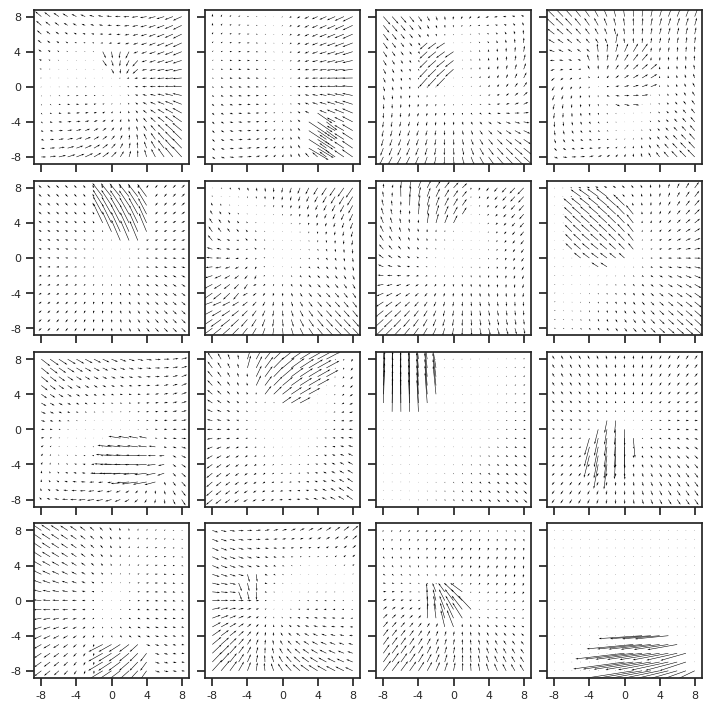

In [9]:
show_opticflow(of.alpha_dot[accept]);

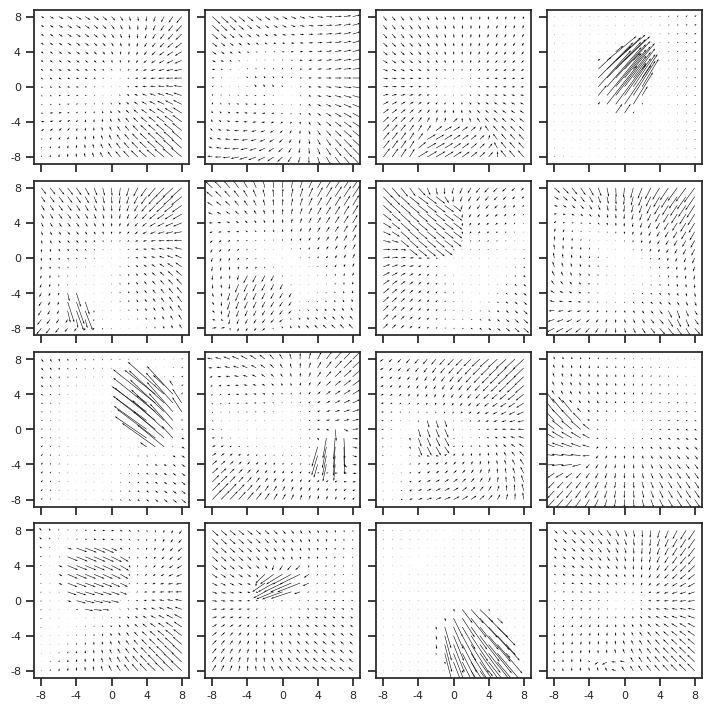

In [9]:
# _ = show_opticflow(resize(of.alpha_dot[accept][:16], (16, 17, 17, 2)))

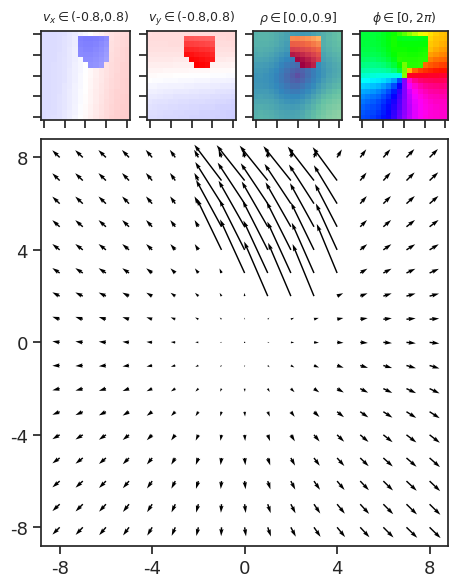

In [10]:
_ = show_opticflow_full(of.alpha_dot[accept][4])

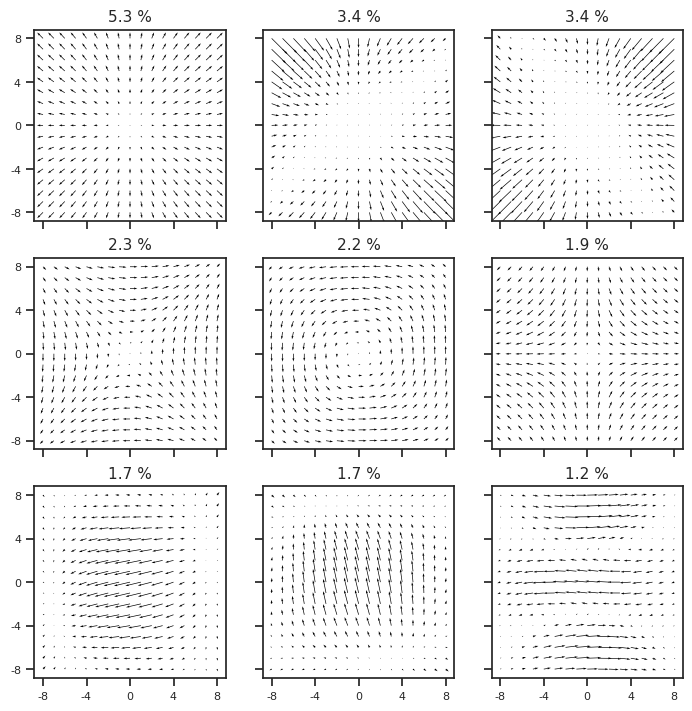

In [11]:
show_opticflow(pcs[:9], num=3, titles=titles, scale=None);

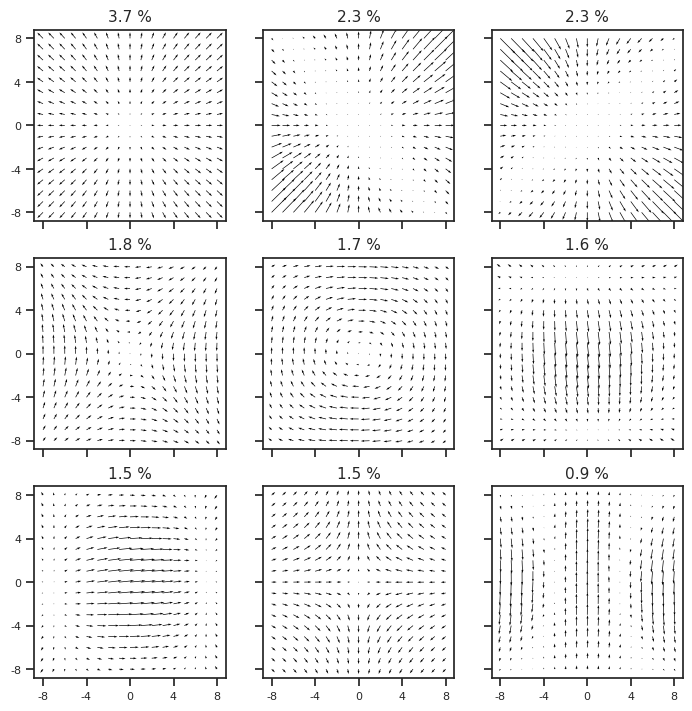

In [11]:
# show_opticflow(resize(pcs[:9], (9, 17, 17, 2)), num=3, titles=titles, scale=None);

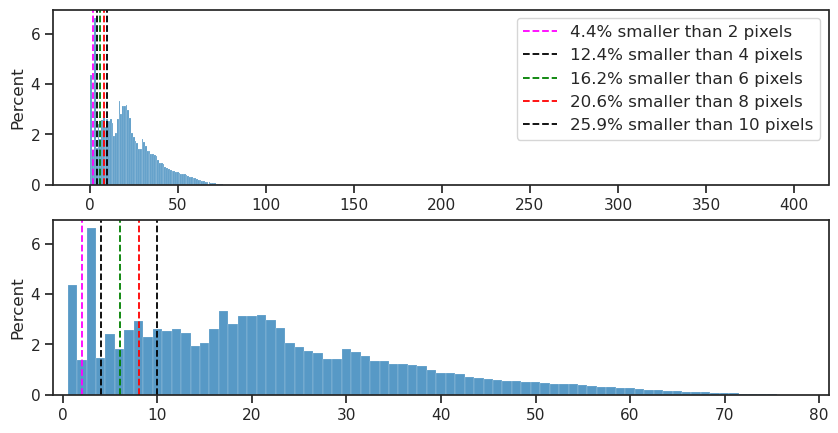

In [12]:
_sizes_hist(of)

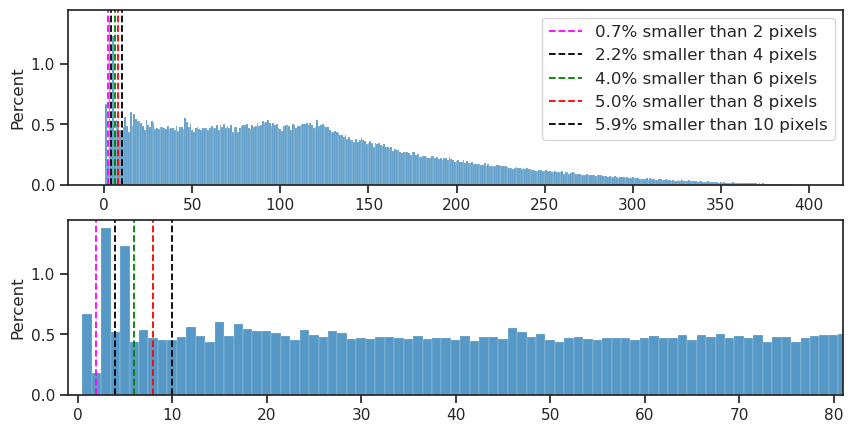

In [12]:
_sizes_hist(of)

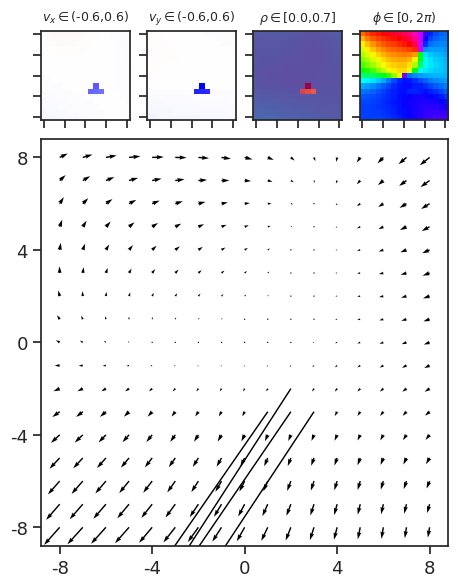

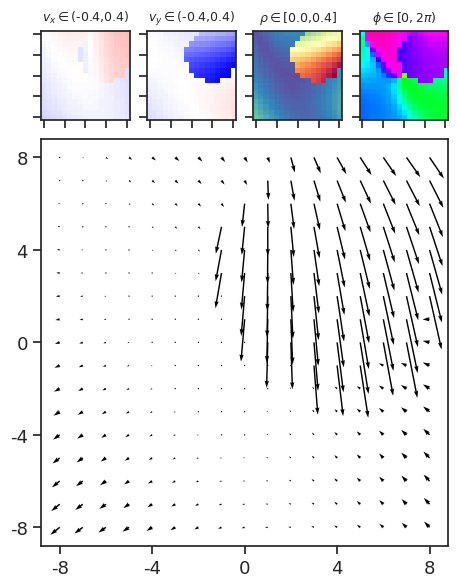

In [13]:
size_pix = of.objects[0].size * of.dim ** 2
i = np.argmin(size_pix[accept])
_ = show_opticflow_full(of.alpha_dot[accept][i])

i = np.argsort(size_pix[accept])[-1]
_ = show_opticflow_full(of.alpha_dot[accept][i])

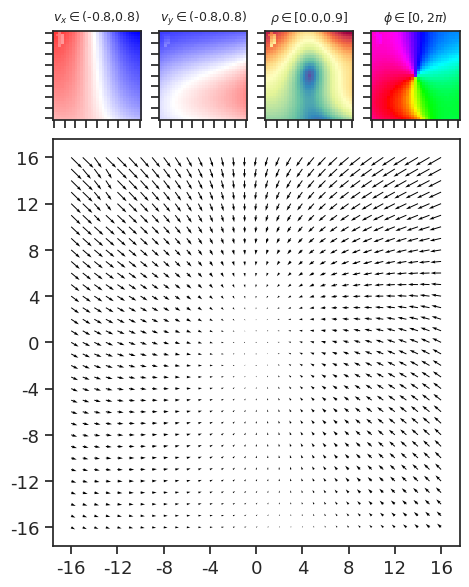

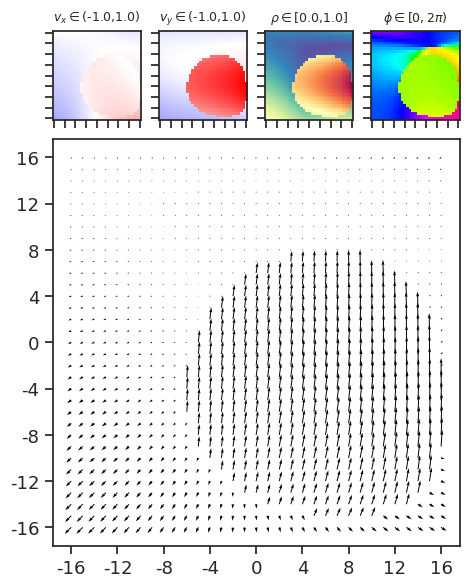

In [13]:
"""size_pix = of.objects[0].size * of.dim ** 2
i = np.argmin(size_pix[accept])
_ = show_opticflow_full(of.alpha_dot[accept][i])

i = np.argsort(size_pix[accept])[-1]
_ = show_opticflow_full(of.alpha_dot[accept][i])"""

In [14]:
np.min(size_pix[accept]), np.max(size_pix[accept])

(4.0, 81.00000000000003)

In [14]:
# np.min(size_pix[accept]), np.max(size_pix[accept])

(10.999999999999996, 419.0)

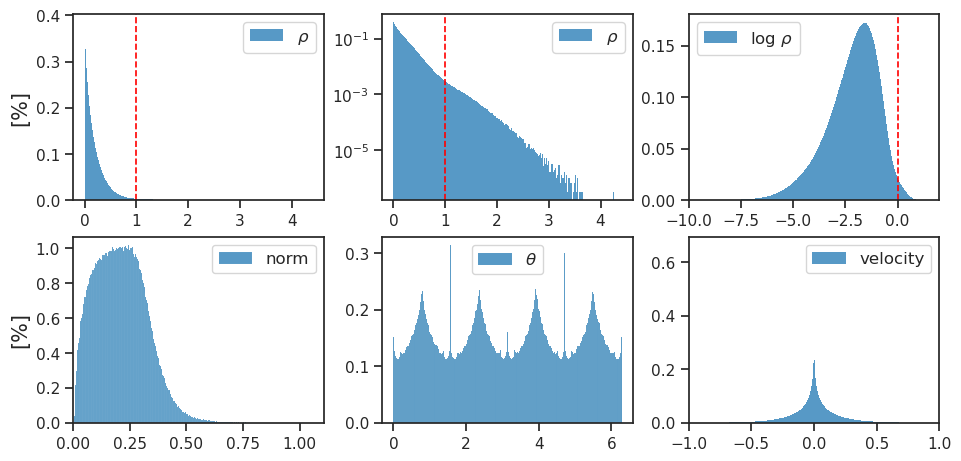

CPU times: user 21min 11s, sys: 6min 38s, total: 27min 49s
Wall time: 27min 50s


In [15]:
%%time

_ = plot_opticflow_hist(of.alpha_dot[accept])

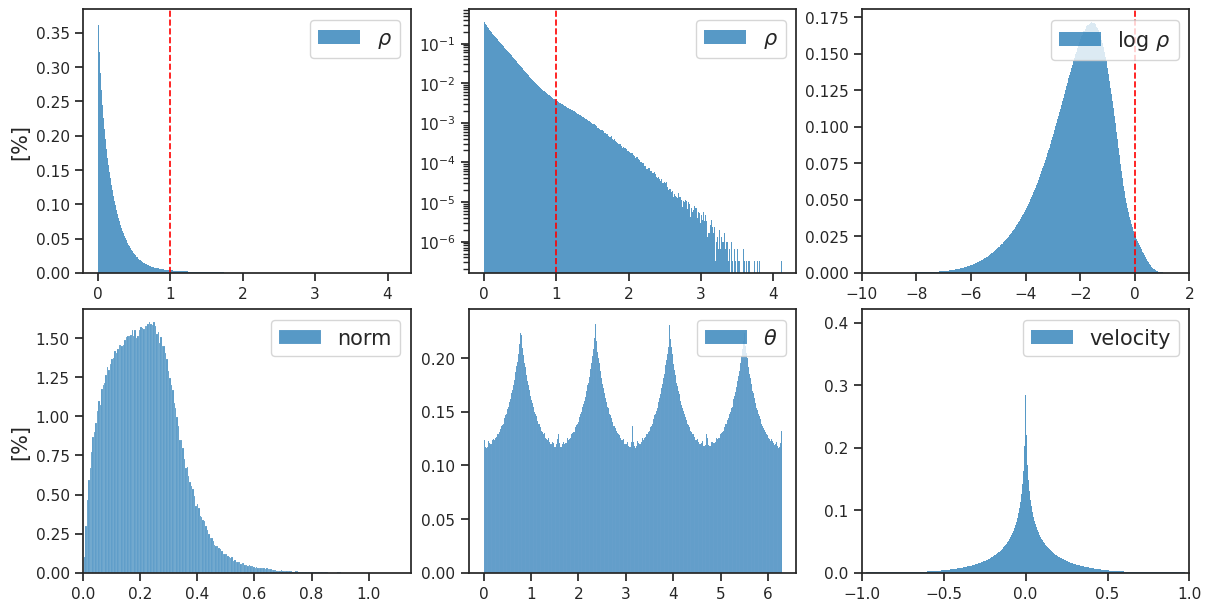

CPU times: user 16min 41s, sys: 6min 17s, total: 22min 59s
Wall time: 22min 59s


In [15]:
%%time

_ = plot_opticflow_hist(of.alpha_dot[accept])

## Other hists

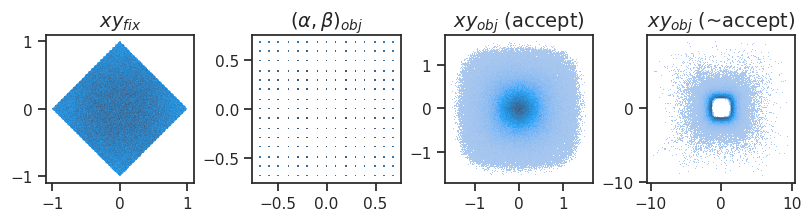

In [16]:
fig, axes = create_figure(1, 4, (8, 3.5), layout='constrained')
sns.histplot(
    x=of.fix[accept, 0],
    y=of.fix[accept, 1],
    ax=axes[0],
)
sns.histplot(
    x=of.objects[0].alpha[accept, 0],
    y=of.objects[0].alpha[accept, 1],
    ax=axes[1],
)
sns.histplot(
    x=of.objects[0].pos[accept, 0],
    y=of.objects[0].pos[accept, 1],
    ax=axes[2],
)
sns.histplot(
    x=of.objects[0].pos[~accept, 0],
    y=of.objects[0].pos[~accept, 1],
    ax=axes[3],
)

axes[0].set_title(r"$xy_{fix}$", fontsize=14)
axes[1].set_title(r"$(\alpha,\beta)_{obj}$", fontsize=14)
axes[2].set_title(r"$xy_{obj}$ (accept)", fontsize=14)
axes[3].set_title(r"$xy_{obj}$ (~accept)", fontsize=14)

ax_square(axes)
plt.show()

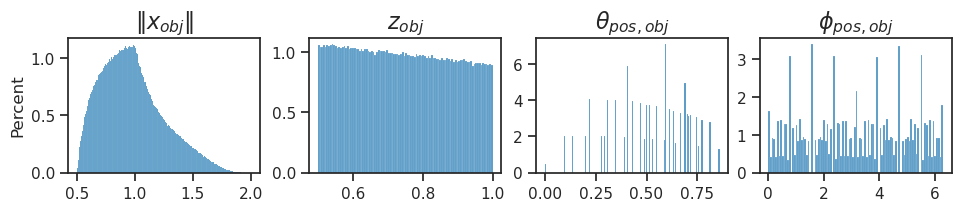

In [17]:
fig, axes = create_figure(1, 4, (9.5, 2), constrained_layout=True)
sns.histplot(of.objects[0].r[accept, 0], stat='percent', ax=axes[0])
sns.histplot(of.objects[0].pos[accept, 2], stat='percent', ax=axes[1])
sns.histplot(of.objects[0].r[accept, 1], stat='percent', ax=axes[2])
sns.histplot(of.objects[0].r[accept, 2], stat='percent', ax=axes[3])

axes[0].set_title(r"$\|x_{obj}\|$", fontsize=16)
axes[1].set_title(r"$z_{obj}$", fontsize=16)
axes[2].set_title(r"$\theta_{pos, obj}$", fontsize=16)
axes[3].set_title(r"$\phi_{pos, obj}$", fontsize=16)

for ax in axes[1:].flat:
    ax.set_ylabel('')
plt.show()

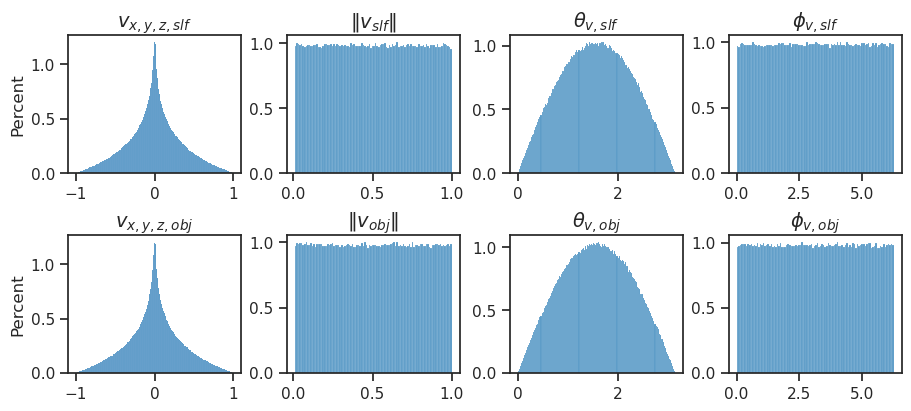

In [18]:
v_slf_polar = cart2polar(of.v_slf)
v_obj_polar = cart2polar(of.objects[0].v)

fig, axes = create_figure(2, 4, (9, 4), constrained_layout=True)

sns.histplot(of.v_slf[accept].ravel(), stat='percent', ax=axes[0, 0])
sns.histplot(v_slf_polar[accept, 0], stat='percent', ax=axes[0, 1])
sns.histplot(v_slf_polar[accept, 1], stat='percent', ax=axes[0, 2])
sns.histplot(v_slf_polar[accept, 2], stat='percent', ax=axes[0, 3])

sns.histplot(of.objects[0].v[accept].ravel(), stat='percent', ax=axes[1, 0])
sns.histplot(v_obj_polar[accept, 0], stat='percent', ax=axes[1, 1])
sns.histplot(v_obj_polar[accept, 1], stat='percent', ax=axes[1, 2])
sns.histplot(v_obj_polar[accept, 2], stat='percent', ax=axes[1, 3])

axes[0, 0].set_title(r"$v_{x,y,z, slf}$", fontsize=14)
axes[1, 0].set_title(r"$v_{x,y,z, obj}$", fontsize=14)
axes[0, 1].set_title(r"$\|v_{slf}\|$", fontsize=14)
axes[1, 1].set_title(r"$\|v_{obj}\|$", fontsize=14)
axes[0, 2].set_title(r"$\theta_{v, slf}$", fontsize=14)
axes[1, 2].set_title(r"$\theta_{v, obj}$", fontsize=14)
axes[0, 3].set_title(r"$\phi_{v, slf}$", fontsize=14)
axes[1, 3].set_title(r"$\phi_{v, obj}$", fontsize=14)

for ax in axes[:, 1:].flat:
    ax.set_ylabel('')
plt.show()

## Correlations (all of data)

In [19]:
f, g, f_aux, g_aux = of.groundtruth_factors()

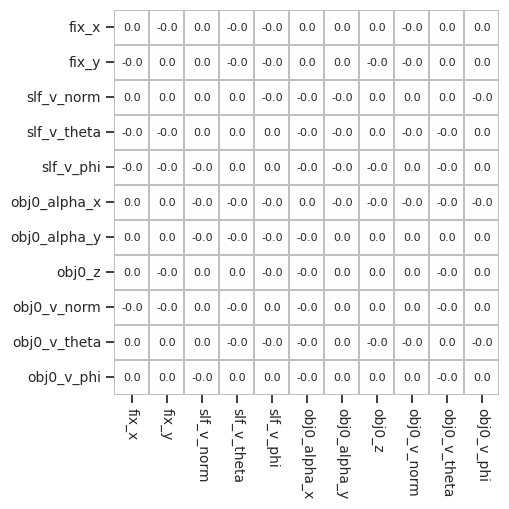

In [20]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g.T, metric='correlation'))
np.fill_diagonal(rho, 0)

kws = dict(
    xticklabels=f,
    yticklabels=f,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(5, 5),
    cbar=False,
)
plot_heatmap(rho, **kws);

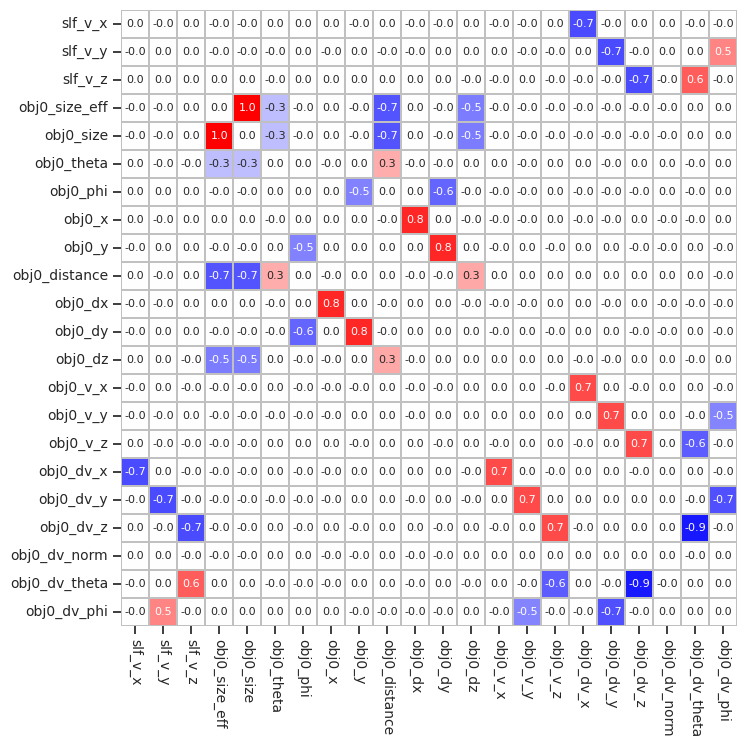

In [21]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g_aux.T, metric='correlation'))
np.fill_diagonal(rho, 0)

kws = dict(
    xticklabels=f_aux,
    yticklabels=f_aux,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(8, 8),
    cbar=False,
)
plot_heatmap(rho, **kws);

In [22]:
g_full = np.concatenate([g, g_aux], axis=1)
g_full.shape

(1200000, 33)

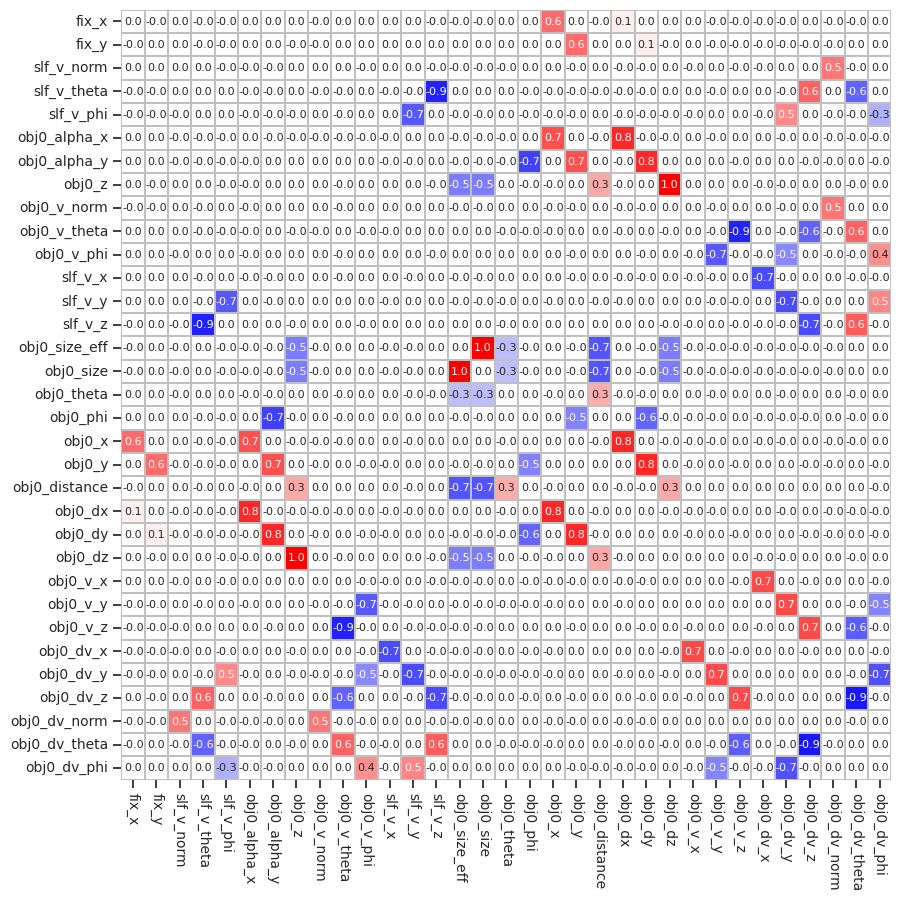

In [23]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g_full.T, metric='correlation'))
np.fill_diagonal(rho, 0)

kws = dict(
    xticklabels=f + f_aux,
    yticklabels=f + f_aux,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(10, 10),
    cbar=False,
)
plot_heatmap(rho, **kws);

## Correlations (accepted only)

In [24]:
f, g, f_aux, g_aux = of.groundtruth_factors()
g, g_aux = g[accept], g_aux[accept]

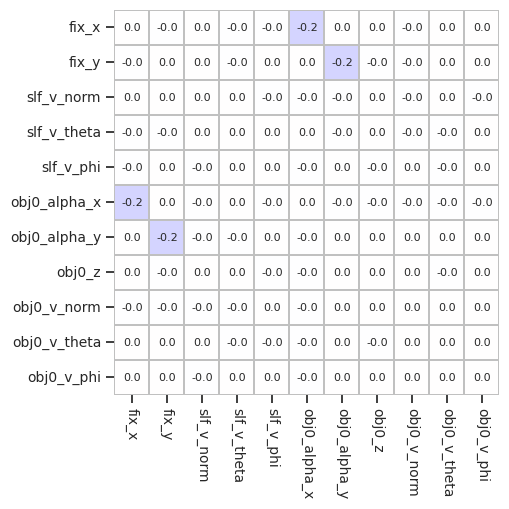

In [25]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g.T, metric='correlation'))
np.fill_diagonal(rho, 0)

kws = dict(
    xticklabels=f,
    yticklabels=f,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(5, 5),
    cbar=False,
)
plot_heatmap(rho, **kws);

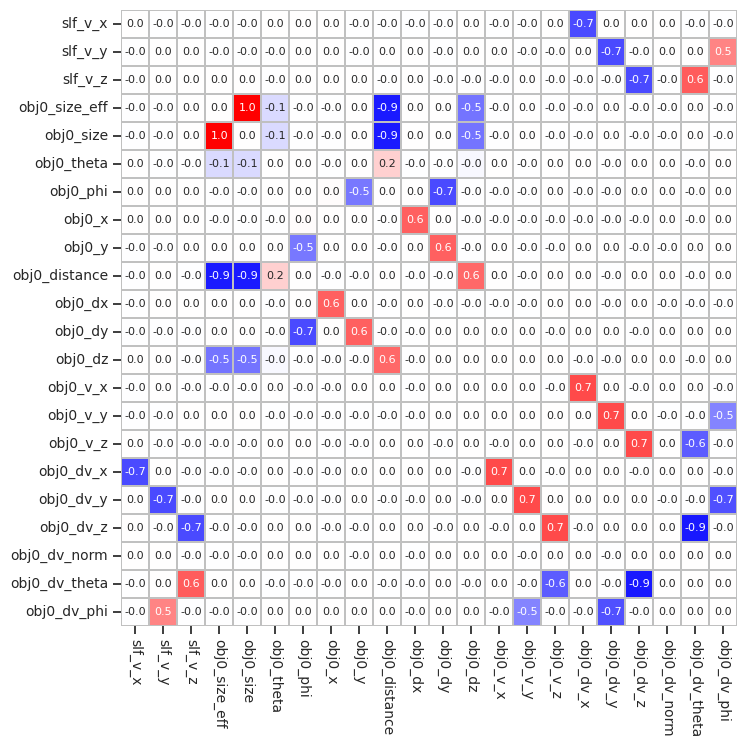

In [26]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g_aux.T, metric='correlation'))
np.fill_diagonal(rho, 0)

kws = dict(
    xticklabels=f_aux,
    yticklabels=f_aux,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(8, 8),
    cbar=False,
)
plot_heatmap(rho, **kws);

In [27]:
g_full = np.concatenate([g, g_aux], axis=1)
g_full.shape

(1051612, 33)

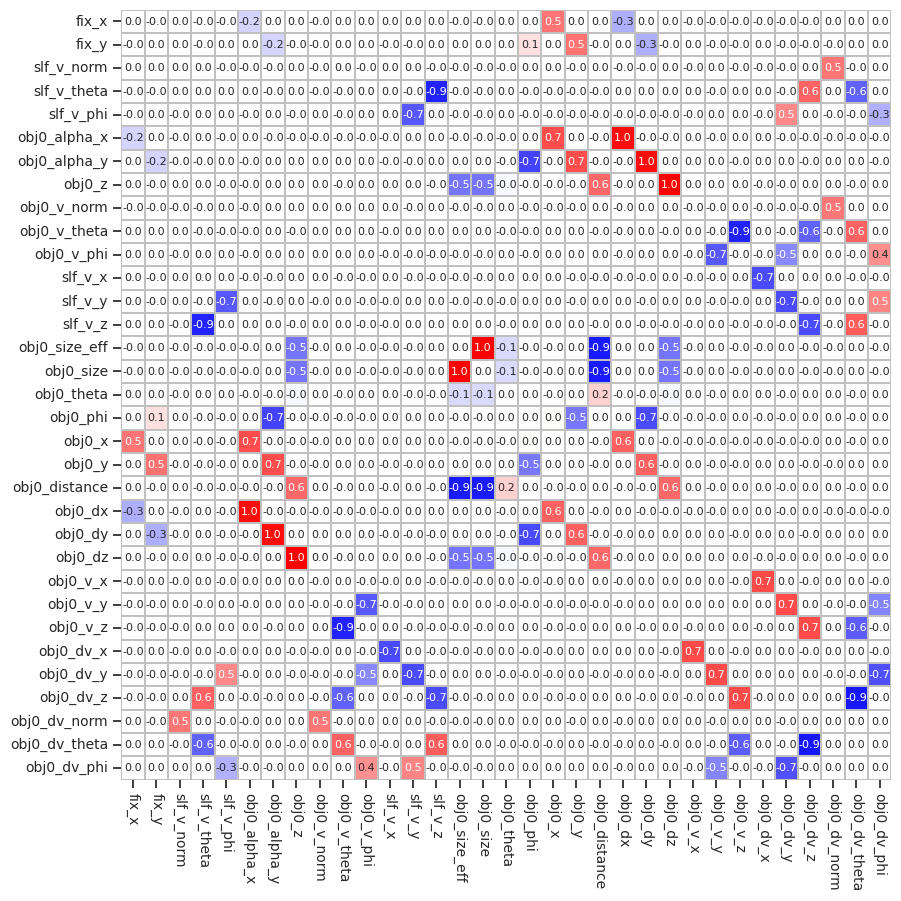

In [28]:
rho = 1 - sp_dist.squareform(sp_dist.pdist(
    g_full.T, metric='correlation'))
np.fill_diagonal(rho, 0)

kws = dict(
    xticklabels=f + f_aux,
    yticklabels=f + f_aux,
    tick_labelsize_x=10,
    tick_labelsize_y=10,
    figsize=(10, 10),
    cbar=False,
)
plot_heatmap(rho, **kws);

## Print generative factors

- After fixing the bug in terrain

In [29]:
kws['n'] = 1000
for category, n_obj in combos:
    kws['category'] = category
    kws['n_obj'] = n_obj
    of = ROFL(**kws).compute_coords()
    _ = of.compute_flow()
    f, g, f_aux, g_aux = of.groundtruth_factors()
    f_with_mu_sig = {}
    for k, v in zip(f, g.T):
        mu, sd = np.mean(v), np.std(v)
        if sd < 1e-3:
            raise RuntimeError
        f_with_mu_sig[k] = (np.round(mu, 3), np.round(sd, 3))
    f_aux_with_mu_sig = {}
    for k, v in zip(f_aux, g_aux.T):
        mu, sd = np.mean(v), np.std(v)
        if sd < 1e-3:
            raise RuntimeError
        f_aux_with_mu_sig[k] = (np.round(mu, 3), np.round(sd, 3))
    print('-' * 80, f"\ncategory: {category}, n_obj = {n_obj}")
    print(f"factors:\n{f_with_mu_sig}")
    print(f"factors_aux:\n{f_aux_with_mu_sig}\n", '~' * 80)
    print('\n\n')

-------------------------------------------------------------------------------- 
category: fixate, n_obj = 0

factors:
{'fix_x': (0.023, 0.402), 'fix_y': (-0.01, 0.411), 'slf_v_norm': (2.53, 1.481), 
'slf_v_theta': (1.591, 0.685), 'slf_v_phi': (3.159, 1.825)}

factors_aux:
{'slf_v_x': (0.012, 1.738), 'slf_v_y': (-0.007, 1.673), 'slf_v_z': (-0.025, 1.665)}
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

-------------------------------------------------------------------------------- 
category: fixate, n_obj = 1

factors:
{'fix_x': (0.023, 0.402), 'fix_y': (-0.01, 0.411), 'slf_v_norm': (2.53, 1.481), 
'slf_v_theta': (1.591, 0.685), 'slf_v_phi': (3.159, 1.825), 'obj0_alpha_x': (-0.004, 0.449), 
'obj0_alpha_y': (0.006, 0.447), 'obj0_z': (0.753, 0.143), 'obj0_v_norm': (2.479, 1.418), 
'obj0_v_theta': (1.616, 0.694), 'obj0_v_phi': (3.116, 1.816)}

factors_aux:
{'slf_v_x': (0.012, 1.738), 'slf_v_y': (-0.007, 1.673), 'slf_v_z': (-0.025, 1.665), 
'obj0_size_eff': (0.073, 0.054), 'obj0_size': (0.073, 0.054), 'obj0_theta': (0.568, 0.199), 
'obj0_phi': (3.128, 1.795), 'obj0_x': (0.03, 0.797), 'obj0_y': (0.018, 0.819), 
'obj0_distance': (1.195, 0.683), 'obj0_dx': (0.006, 0.671), 'obj0_dy': (0.029, 0.669), 
'obj0_dz': (-0.247, 0.143), 'obj0_v_x': (0.049, 1.632), 'obj0_v_y': (0.065, 1.648), 
'obj0_v_z': (-0.077, 1.664), 'obj0_dv_x': (0.037, 2.398), 'obj0_dv_y': (0.072, 2.373), 
'obj0_dv_z': (-0.052, 2.337), 'obj0_dv_norm': (3.727, 1.719), 'obj0_dv_theta': (1.596, 
0.686), 'obj0_dv_phi': (3.082, 1.841)}
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

-------------------------------------------------------------------------------- 
category: transl, n_obj = 0

factors:
{'fix_x': (0.023, 0.402), 'fix_y': (-0.01, 0.411), 'slf_v_norm': (2.53, 1.481), 
'slf_v_theta': (1.591, 0.685), 'slf_v_phi': (3.159, 1.825)}

factors_aux:
{'slf_v_x': (0.012, 1.738), 'slf_v_y': (-0.007, 1.673), 'slf_v_z': (-0.025, 1.665)}
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

-------------------------------------------------------------------------------- 
category: transl, n_obj = 1

factors:
{'fix_x': (0.023, 0.402), 'fix_y': (-0.01, 0.411), 'slf_v_norm': (2.53, 1.481), 
'slf_v_theta': (1.591, 0.685), 'slf_v_phi': (3.159, 1.825), 'obj0_alpha_x': (-0.004, 0.449), 
'obj0_alpha_y': (0.006, 0.447), 'obj0_z': (0.753, 0.143), 'obj0_v_norm': (2.479, 1.418), 
'obj0_v_theta': (1.616, 0.694), 'obj0_v_phi': (3.116, 1.816)}

factors_aux:
{'slf_v_x': (0.012, 1.738), 'slf_v_y': (-0.007, 1.673), 'slf_v_z': (-0.025, 1.665), 
'obj0_size_eff': (0.073, 0.054), 'obj0_size': (0.073, 0.054), 'obj0_theta': (0.568, 0.199), 
'obj0_phi': (3.128, 1.795), 'obj0_x': (0.03, 0.797), 'obj0_y': (0.018, 0.819), 
'obj0_distance': (1.195, 0.683), 'obj0_dx': (0.006, 0.671), 'obj0_dy': (0.029, 0.669), 
'obj0_dz': (-0.247, 0.143), 'obj0_v_x': (0.049, 1.632), 'obj0_v_y': (0.065, 1.648), 
'obj0_v_z': (-0.077, 1.664), 'obj0_dv_x': (0.037, 2.398), 'obj0_dv_y': (0.072, 2.373), 
'obj0_dv_z': (-0.052, 2.337), 'obj0_dv_norm': (3.727, 1.719), 'obj0_dv_theta': (1.596, 
0.686), 'obj0_dv_phi': (3.082, 1.841)}
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

-------------------------------------------------------------------------------- 
category: obj, n_obj = 1

factors:
{'fix_x': (0.023, 0.402), 'fix_y': (-0.01, 0.411), 'obj0_alpha_x': (-0.004, 0.449), 
'obj0_alpha_y': (0.006, 0.447), 'obj0_z': (0.753, 0.143), 'obj0_v_norm': (2.479, 1.418), 
'obj0_v_theta': (1.616, 0.694), 'obj0_v_phi': (3.116, 1.816)}

factors_aux:
{'obj0_size_eff': (0.073, 0.054), 'obj0_size': (0.073, 0.054), 'obj0_theta': (0.568, 0.199), 
'obj0_phi': (3.128, 1.795), 'obj0_x': (0.03, 0.797), 'obj0_y': (0.018, 0.819), 
'obj0_distance': (1.195, 0.683), 'obj0_dx': (0.006, 0.671), 'obj0_dy': (0.029, 0.669), 
'obj0_dz': (-0.247, 0.143), 'obj0_v_x': (0.049, 1.632), 'obj0_v_y': (0.065, 1.648), 
'obj0_v_z': (-0.077, 1.664)}
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~